First we need to import all necessary libraries

In [1]:
#Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error,r2_score
import warnings
warnings.filterwarnings('ignore')

### Reading data

In [2]:
#Read_data
Bike_Sharing = pd.read_csv(
    "https://ml-course2-upgrad.s3.amazonaws.com/Linear+Regression+Assignment/Bike+Sharing+Assignment/day.csv"
)
Bike_Sharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### Checking Data

In [3]:
#checking data
Bike_Sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
instant       730 non-null int64
dteday        730 non-null object
season        730 non-null int64
yr            730 non-null int64
mnth          730 non-null int64
holiday       730 non-null int64
weekday       730 non-null int64
workingday    730 non-null int64
weathersit    730 non-null int64
temp          730 non-null float64
atemp         730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
casual        730 non-null int64
registered    730 non-null int64
cnt           730 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### Cleaning Data
For this task, many of the columns in this dataframe are not required. So it is advised to drop the following columns.
'holiday' is needed to predict, but the 'working day' already includes 'holiday' so we don't need that.
'cnt' = 'casual' + 'registered', so we don't need 2 columns either.
And many of the columns in this data are not required like instant, dteday, etc..

In [4]:
#cleaning data
Bike_Sharing = Bike_Sharing.drop(columns=['instant','dteday','season','mnth','holiday','weekday','casual','registered'])

#### Visualizing of variables
Visualizing Continuous Variables

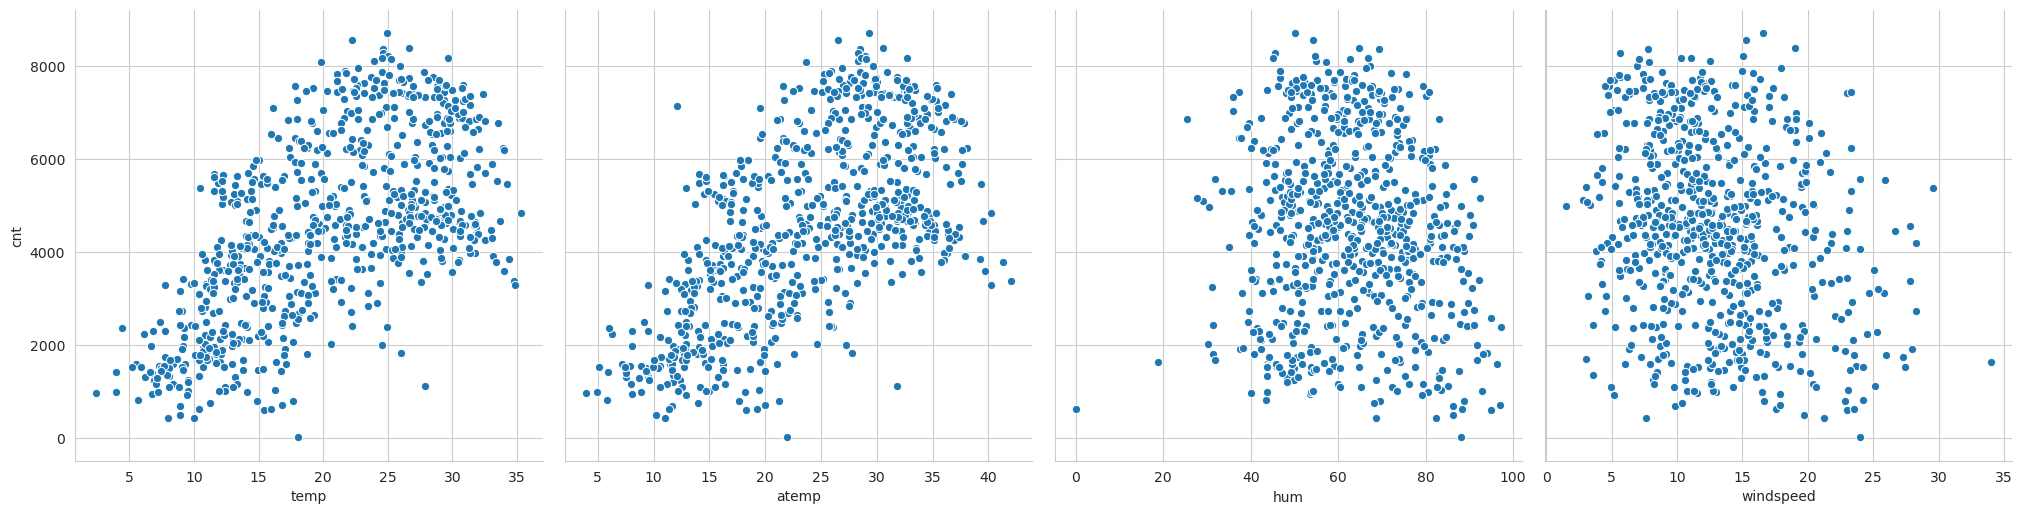

In [5]:
sns.set_style("whitegrid")
sns.pairplot(data=Bike_Sharing,x_vars=['temp','atemp','hum','windspeed'],y_vars='cnt',kind='scatter',height=5,aspect=1);

2 outliers of temp vs cnt between 15 and 30.
2 outliers of atemp vs cnt between 20 and 35.
2 outliers of hum vs cnt below 20.
1 outliers of windspeed vs cnt above 30.

In [6]:
## Dropping outliers in continuous variables
# outliers in temp
Bike_Sharing = Bike_Sharing.drop(index = Bike_Sharing[(Bike_Sharing['temp'] > 15) & (Bike_Sharing['temp'] < 20) & (Bike_Sharing['cnt'] < 100)].index)
Bike_Sharing = Bike_Sharing.drop(index = Bike_Sharing[(Bike_Sharing['temp'] > 25) & (Bike_Sharing['temp'] < 30) & (Bike_Sharing['cnt'] < 2000)].index)


# outliers in atemp
Bike_Sharing = Bike_Sharing.drop(index = Bike_Sharing[(Bike_Sharing['atemp'] > 20) & (Bike_Sharing['atemp'] < 25) & (Bike_Sharing['cnt'] < 100)].index)
Bike_Sharing = Bike_Sharing.drop(index = Bike_Sharing[(Bike_Sharing['atemp'] > 30) & (Bike_Sharing['atemp'] < 35) & (Bike_Sharing['cnt'] < 2000)].index)


#outliers in hum
Bike_Sharing = Bike_Sharing.drop(index = Bike_Sharing[(Bike_Sharing['hum'] < 20)].index)

#outliers in windspeed
Bike_Sharing = Bike_Sharing.drop(index = Bike_Sharing[(Bike_Sharing['windspeed'] > 30)].index)

In [7]:
# Looking at correlation with continuous variables 
correlation = Bike_Sharing[['temp','atemp','hum','windspeed','cnt']].corr()['cnt'].apply(lambda x : round(x,4))
correlation = pd.DataFrame(correlation).sort_values(by='cnt',ascending=False)
correlation.drop(index=['cnt'],inplace=True)
# dropping registered,casual, instant
correlation.style.background_gradient(cmap='GnBu')

,cnt
atemp,0.6389
temp,0.6356
hum,-0.1076
windspeed,-0.2181


adjusted temp has the highest positive correlation.
hum has the lowest correlation.

In [8]:
Bike_Sharing[['temp','atemp']].corr()

,temp,atemp
temp,1.000000,0.991726
atemp,0.991726,1.000000


we can drop one of them.

In [9]:
Bike_Sharing = Bike_Sharing.drop(columns=['atemp'])
#check others
Bike_Sharing[['temp','hum','windspeed']].corr()

,temp,hum,windspeed
temp,1.000000,0.122673,-0.160295
hum,0.122673,1.000000,-0.247498
windspeed,-0.160295,-0.247498,1.000000


In [10]:
no significant correlation then we can't drop anymore.

SyntaxError: invalid syntax (3243764532.py, line 1)

#### Visualizing of variables
Visualizing Continuous Variables

In [11]:
Bike_Sharing[['weathersit']] = Bike_Sharing[['weathersit']].astype('category')
weathersit_labels = {
    1 : 'clear',
    2 : 'cloudy',
    3 : 'light snow/rain',
    4 : 'heavy rain'
}
Bike_Sharing['weathersit'] = Bike_Sharing['weathersit'].replace(weathersit_labels)
Bike_Sharing.head()

,yr,workingday,weathersit,temp,hum,windspeed,cnt
0,0,0,cloudy,14.110847,80.5833,10.749882,985
1,0,0,cloudy,14.902598,69.6087,16.652113,801
2,0,1,clear,8.050924,43.7273,16.636703,1349
3,0,1,clear,8.200000,59.0435,10.739832,1562
4,0,1,clear,9.305237,43.6957,12.522300,1600


#### Correlation

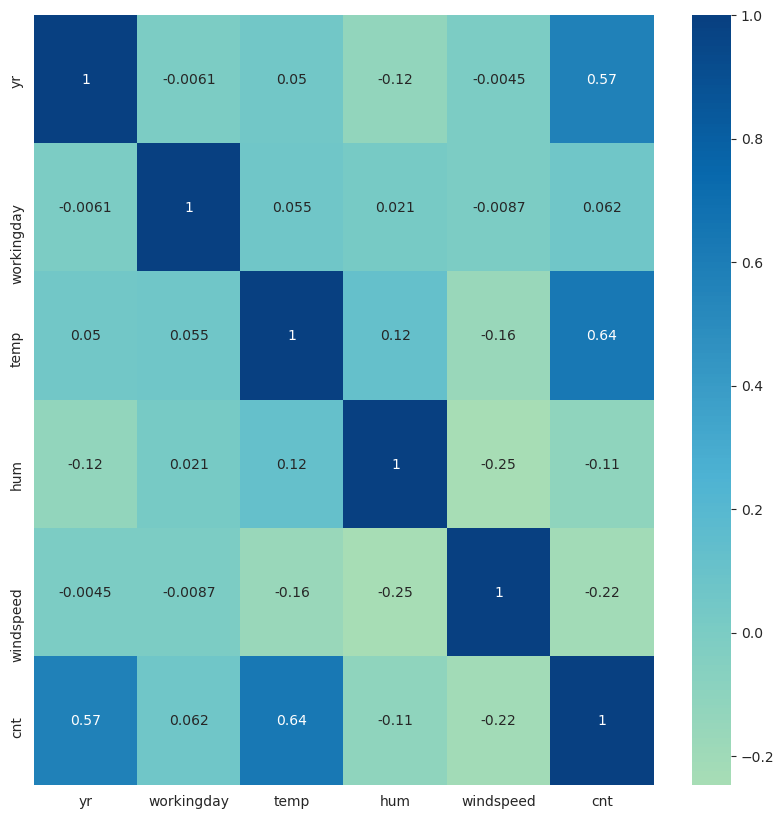

In [12]:
# correlation among variables
plt.figure(figsize=[10,10])
sns.heatmap(Bike_Sharing.corr(),cmap='GnBu',center=0,annot=True)

#### Data Preparation

In [13]:
# creating indicator variable columns
weathersit_indicators = pd.get_dummies(Bike_Sharing['weathersit'],drop_first=True)

In [14]:
# adding indicator variable columns to the dataset . Dropping original columns
Bike_Sharing = pd.concat([Bike_Sharing,weathersit_indicators],axis=1)
Bike_Sharing = Bike_Sharing.drop(columns=['weathersit'])
Bike_Sharing.head()

,yr,workingday,temp,hum,windspeed,cnt,cloudy,light snow/rain
0,0,0,14.110847,80.5833,10.749882,985,1,0
1,0,0,14.902598,69.6087,16.652113,801,1,0
2,0,1,8.050924,43.7273,16.636703,1349,0,0
3,0,1,8.200000,59.0435,10.739832,1562,0,0
4,0,1,9.305237,43.6957,12.522300,1600,0,0


#### Training

In [15]:
dtrain,dtest = train_test_split(Bike_Sharing,train_size=0.7,test_size=0.3,random_state=120)

In [16]:
# normalization of continuous variables
from sklearn.preprocessing import MinMaxScaler 
numerical_scaler = MinMaxScaler()
num_vars = ['temp','hum','windspeed']

numerical_scaler.fit(dtrain[num_vars])
dtrain[num_vars] = numerical_scaler.transform(dtrain[num_vars])

In [17]:
y_train = dtrain.pop('cnt')
X_train = dtrain
y_train.head()

16     1000
609    5810
272    5202
107    3429
720    1749
Name: cnt, dtype: int64

In [18]:
X_train.head()

,yr,workingday,temp,hum,windspeed,cloudy,light snow/rain
16,0,0,0.147718,0.394431,0.379986,1,0
609,1,0,0.806971,0.780742,0.054518,1,0
272,0,1,0.639257,0.547564,0.411189,0,0
107,0,1,0.573859,0.401392,0.303720,0,0
720,1,0,0.261637,0.260440,0.914299,0,0


In [19]:
X_train.columns

Index(['yr', 'workingday', 'temp', 'hum', 'windspeed', 'cloudy',
       'light snow/rain'],
      dtype='object')

#### Modelling

In [20]:
lr_estimator = LinearRegression()
rfe = RFE(lr_estimator,n_features_to_select=15, step=1)
selector = rfe.fit(X_train,y_train)
# RFE Feature Ranking
rfe_ranking = pd.DataFrame({'rank' : selector.ranking_, 'support': selector.support_, 'features' : X_train.columns}).sort_values(by='rank',ascending=True)
rfe_ranking

,rank,support,features
0,1,True,yr
1,1,True,workingday
2,1,True,temp
3,1,True,hum
4,1,True,windspeed
5,1,True,cloudy
6,1,True,light snow/rain


In [21]:
# Selected Features
selected_features = rfe_ranking.loc[rfe_ranking['rank'] == 1,'features'].values
selected_features

array(['yr', 'workingday', 'temp', 'hum', 'windspeed', 'cloudy',
       'light snow/rain'], dtype=object)

#### Manual Elimination

In [22]:
# Following a stepwise elimination
def ols_fit(y,X) : 
    X_train_sm = sm.add_constant(X)
    model = sm.OLS(y,X_train_sm).fit()
    print(model.summary())
    return model
def vif(X) : 
    df = sm.add_constant(X)
    vif = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    vif_frame = pd.DataFrame({'vif' : vif[0:]},index = df.columns).reset_index()
    print(vif_frame.sort_values(by='vif',ascending=False))

In [23]:
features_1 = selected_features
ols_fit(y_train,X_train[features_1])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     228.7
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          3.01e-151
Time:                        22:15:07   Log-Likelihood:                -4188.2
No. Observations:                 507   AIC:                             8392.
Df Residuals:                     499   BIC:                             8426.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1523.8541    223.068     

#### Verifying MultiCollinearity

In [24]:
vif(X_train[selected_features])

             index        vif
0            const  28.330159
4              hum   1.992469
6           cloudy   1.671228
7  light snow/rain   1.317358
5        windspeed   1.157804
3             temp   1.087897
1               yr   1.027784
2       workingday   1.012855


VIF<5

In [25]:
final_model = ols_fit(y_train,X_train[selected_features])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     228.7
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          3.01e-151
Time:                        22:15:09   Log-Likelihood:                -4188.2
No. Observations:                 507   AIC:                             8392.
Df Residuals:                     499   BIC:                             8426.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1523.8541    223.068     

#### Residual Analysis

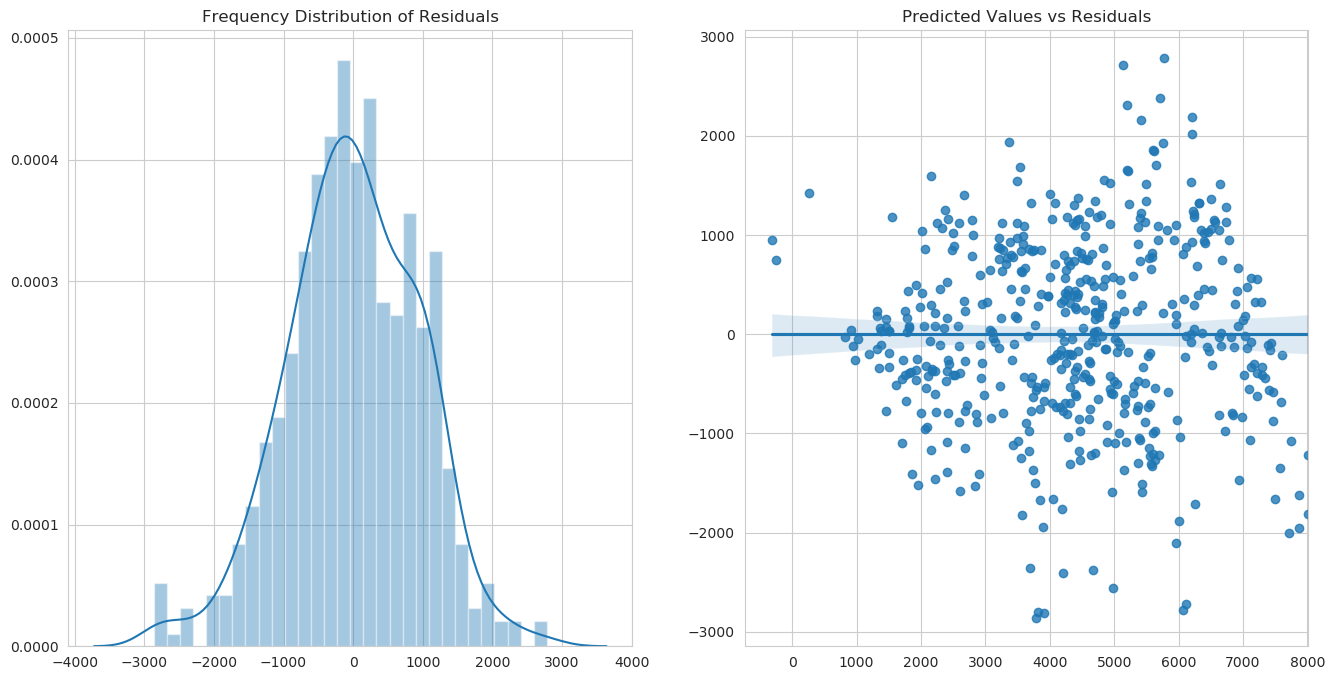

In [26]:
# Residual Analysis of Trained Data
X_train_sm = sm.add_constant(X_train[selected_features])

y_train_pred = final_model.predict(X_train_sm)
fig,ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

ax[0].set(title='Frequency Distribution of Residuals')
sns.distplot(y_train-y_train_pred, bins=30, ax=ax[0])

ax[1].set(title='Predicted Values vs Residuals')
\
sns.regplot(y_train_pred,y_train-y_train_pred,ax=ax[1])
plt.show()

In [27]:
# Mean of Residuals
(y_train-y_train_pred).mean()

9.364028290443166e-13

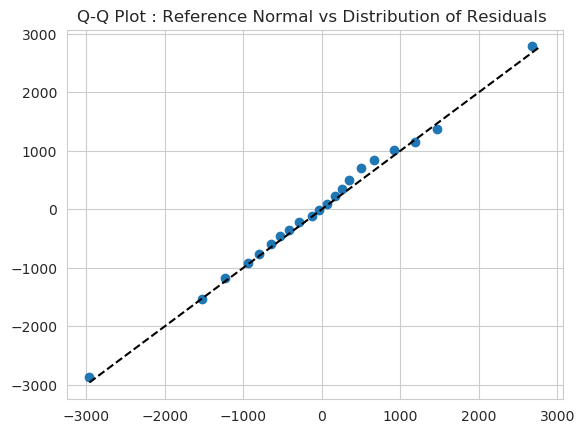

In [28]:
# Verifying the normality of distribution of residuals 
mean = (y_train-y_train_pred).mean()
std = (y_train-y_train_pred).std()

ref_normal = np.random.normal(mean,std,(y_train-y_train_pred).shape[0])


percs = np.linspace(0,100,21)
qn_ref_normal = np.percentile(ref_normal, percs)
qn_residual = np.percentile(y_train - y_train_pred , percs)

plt.plot(qn_ref_normal,qn_residual, ls="", marker="o")

x = np.linspace(np.min((qn_ref_normal.min(),qn_residual.min())), np.max((qn_ref_normal.max(),qn_residual.max())))
plt.plot(x,x, color="k", ls="--")
plt.title('Q-Q Plot : Reference Normal vs Distribution of Residuals ')
plt.show()

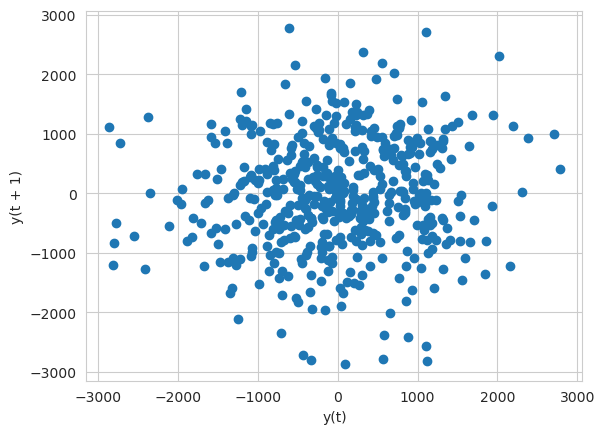

In [29]:
# lag plot to assess independence of data points
lag_plot(y_train-y_train_pred)

#### Prediction

In [30]:
y_test = dtest.pop('cnt')
X_test = dtest
X_test[num_vars] = numerical_scaler.transform(X_test[num_vars])
X_test = X_test[selected_features]

In [31]:
X_test = sm.add_constant(X_test)
y_test_pred = final_model.predict(X_test)

#### Model Evaluation

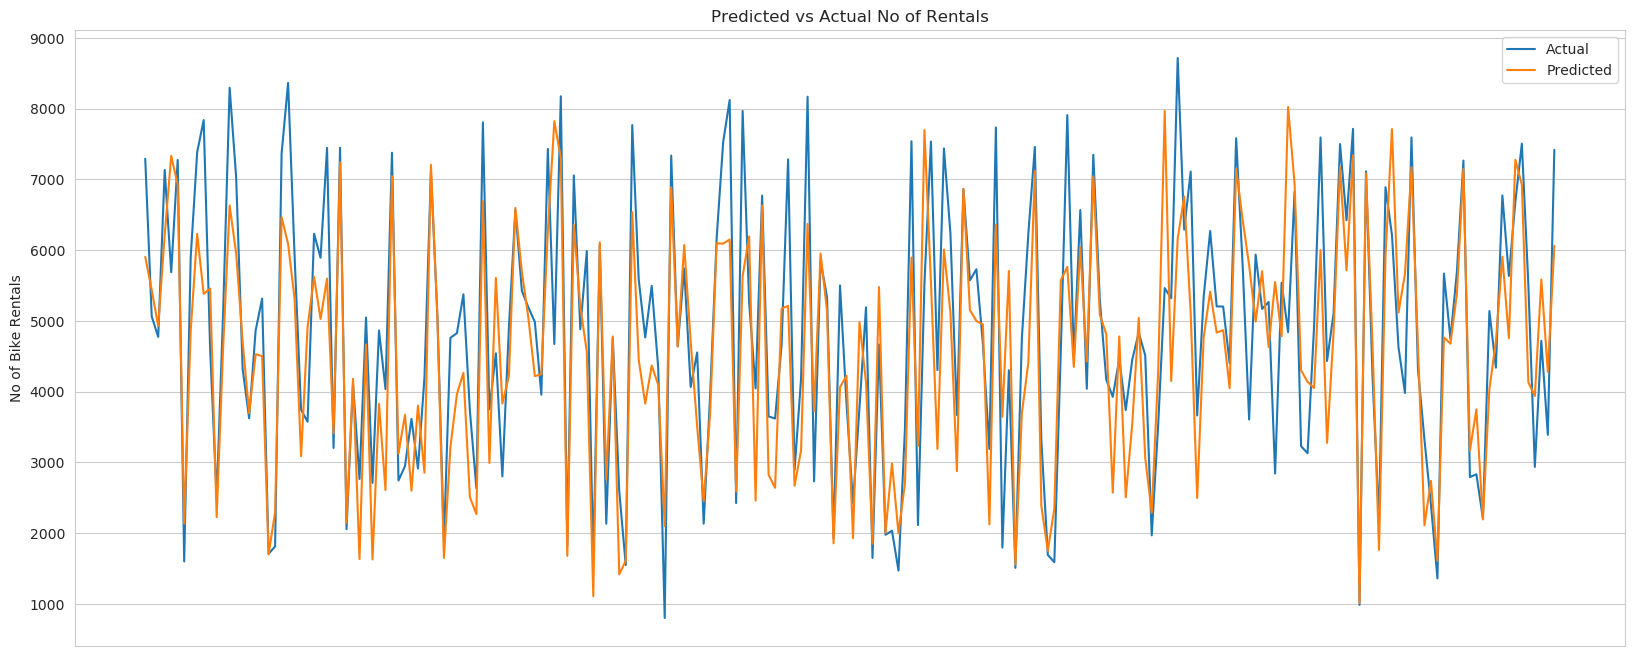

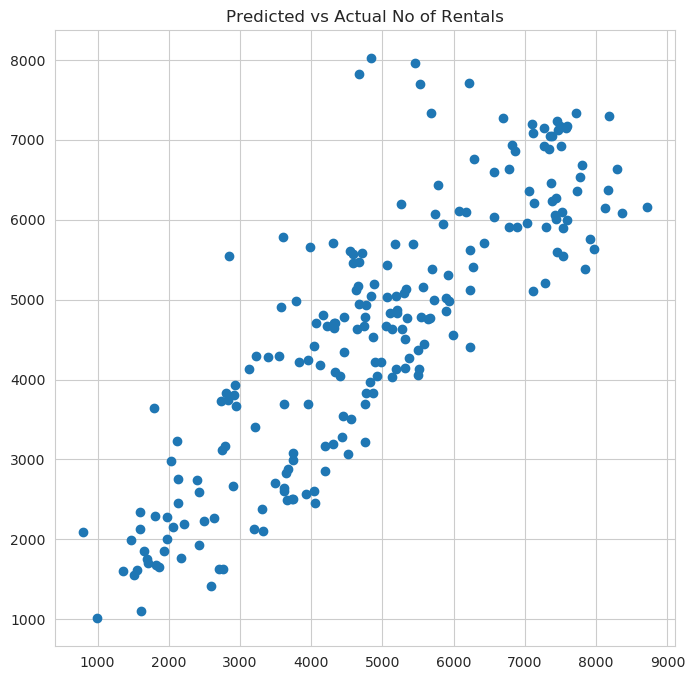

In [32]:
# Plotting Actual vs Predicted No of rentals 
fig,ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
l1,=ax.plot(range(len(y_test)),y_test)
l2, = ax.plot(range(len(y_test_pred)),y_test_pred)
plt.legend([l1,l2],['Actual','Predicted'])
plt.title('Predicted vs Actual No of Rentals');
plt.ylabel('No of Bike Rentals')
plt.xticks([])
plt.show()

plt.figure(figsize=[8,8])
plt.scatter(y_test,y_test_pred);
plt.title('Predicted vs Actual No of Rentals');

Predicted vs observed value plots shows that the model is reasonably accurate

In [33]:
mse = mean_squared_error(y_test, y_test_pred)
rsquared_test = r2_score(y_test, y_test_pred)
rsquared_train = r2_score(y_train, y_train_pred)
print('R-squared for train data:',round(rsquared_train,2))
print('R-squared for test data:',round(rsquared_test,2))
print('Mean Squared Error',round(mse,3))

R-squared for train data: 0.76
R-squared for test data: 0.69
Mean Squared Error 1078038.123


#### Model Stability

In [34]:
lr = LinearRegression()
clr = cross_val_score(lr,X_train[selected_features],y_train,cv=10, scoring='r2')
clr

array([0.78454117, 0.8300331 , 0.69949572, 0.84437582, 0.79514438,
       0.71294087, 0.74312996, 0.49067388, 0.78716341, 0.71775857])

In [35]:
print("R-square at 0.95 confidence level : %0.2f (+/- %0.2f)" % (clr.mean(), clr.std() * 2))

R-square at 0.95 confidence level : 0.74 (+/- 0.19)


In [36]:
# standardizing numerical variables 

reg_features = selected_features
scaler = StandardScaler()
data = X_train[selected_features]
std_num = scaler.fit(data[['temp','windspeed','hum']])


std_X_train = pd.DataFrame(data = scaler.transform(data[['temp','windspeed','hum']]), columns=['temp','windspeed','hum'])
for i in reg_features : 
    std_X_train[i] = data[i].values


reshaped_y_train = y_train.values.reshape(-1,1)

# Fitting linear regression model 
std_model = lr.fit(std_X_train, reshaped_y_train)

# Coefficients and intercept
result = pd.DataFrame(data = std_model.coef_, columns = std_X_train.columns, index=['MLR Coefficients']).T
result = result.sort_values(by='MLR Coefficients',ascending=False)
print('\nIntercept :',std_model.intercept_)
result


Intercept : [1523.8540948]


,MLR Coefficients
temp,4994.969612
yr,1970.134914
workingday,120.811844
cloudy,-390.710579
hum,-569.096834
windspeed,-1179.270219
light snow/rain,-1664.883558


So the top features is temp.!